# Trinomial trees for pricing options

We are going to look at a numerical method for pricing options now. We saw that European call (and put) options can be priced using the Black-Scholes formula, which an analytic expression of the various determinants of the option (e.g. current stock price, strike price, volatility, time to maturity etc.) Many options cannot be priced with a closed-form formula. For these one has to use numerical approximation methods.

We focus here on such a method. Today we introduce the so-called trinomial tree method. Later we will expand this into the explicit finite difference method.

Background on these numerical methods can for instance be found in the book by Hull, ''Options, Futures and other Derivatives'' that is also used in courses on derivatives in Groningen.

A more elaborate resource on numerical techniques like this, focussing on the practical implementation in computer code, is the book ''Implementing Derivatives Models'' by Clewlow and Strickland, which I recommend having a look at (it is in the library). This book may also provide you with some ideas for a future valuation project.


Let us start again by importing numpy: run the following cell.

In [ ]:
import numpy as np

We are going to work towards valuing the price of a call option using a so-called trinomial tree. (You might have seen binomial trees before. A trinomial tree is equivalent but slightly easier to work with for us.)

First we are again going to define an array for possible values for the stock price at the end date (maturity) of the option.  

Create an array of three stock prices, called S, with the values 0, 1, and 2. (e.g. use **np.linspace()** to do that). Check that your S indeed looks like [ 0, 1, 2] (Recall that you can create an empty cell in this notebook by pressing **a** for above, or **b** for below, while in *command* mode.)

Next let us construct the related array of pay-offs of a call option with strike price K. Recall, if the stock price is $S$, then the pay-off of the call option is $S-K$ if that is positive, or zero if $S<K$. Check that the following function computes just that. Experiment a bit with this function, and see if it produces the correct output for various values of the strike price, when acting on the array of stock prices S=[0,1,2] that we just defined.

In [ ]:
def call_payoff(strike, S_array):
    # create an array of strikes that is of the same size as the stock price array
    # len() is a functions that measures how big some array is
    length_of_S_array= len(S_array)
    strike_array=strike*np.ones(length_of_S_array)
    # now create an array of that same length (number of elements) that gives the payoff values for a call option
    values=np.maximum(S_array-strike_array,0)
    return values

It is going to be useful to reference to individual elements in this array. For some reason, programmers like to start counting at 0, rather than at 1. So the first element in this array S will be called S[0], the second S[1], and the third S[2]. Check that e.g. S[1] = 1.0 for your array. Also, check that S[3] is not defined. And, surprise, check out what S[-1] is... do you understand?

In [ ]:
S[1]

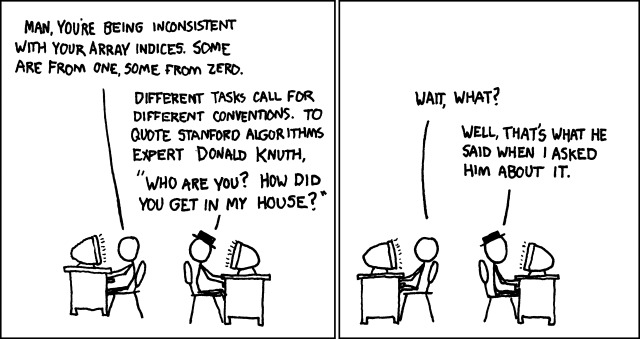

## A trinomial tree

We are going to model the random movements of a stock, between today's value and the value at the option's end date (maturity), using a *trinomial tree*. As an example, suppose we start today at a stock price of $\$ 1$. At maturity, the stock might either go up to a value of $\$ 2$, stay the same at value $ \$ 1$, or go down to value $\$0 $. The probabilities of going up, staying in the middle, and going down will be denoted $p_u, p_m$ and $p_d$. We can depict this process in the following diagram: 

A trinomial tree:
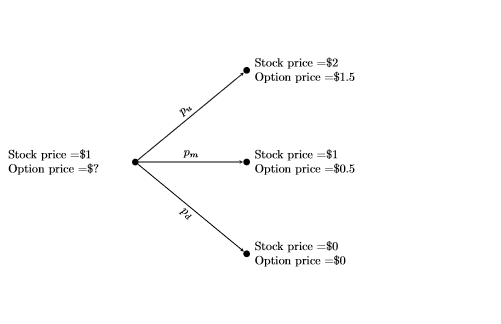

We know the value of the option at the maturity date, which is at the three end states at the ends of the three branches. At that point in time, the option is exercised if the stock price is above the strike price, $S>K$, and ends valueless if it is below the strike price, $S<K$; in other words, value = $\max(S-K,0)$.

Check that the figure depicts the case with a strike price $K=0.5$. In which end points is the option exercised?

We would like to use the tree to compute the value of the option at the starting date, the root of the tree, when $S=1$ but the option still has one period to go until it reaches maturity. The value of this option turns out to be the weighted average of the option values at the ends of the branches, weighted with the probabilities $p_u, p_m, p_d$. (Side note: this is true if we choose these probabilities to be the so-called *risk neutral probabilities*.)

So the initial value, at the starting point, will be
$$
\mbox{option value}= p_u\cdot 1.5 + p_m \cdot 0.5 + p_d \cdot 0.
$$

We are now going to create a function that computes this value of the root of the tree: the weighted average, with probabilities $p_u, p_m, p_d$, of the three pay-offs values.

In [ ]:
def step_back_tree_1(pu,pm,pd, values):
    # values is the array of three end values for the option
    # compute the value by stepping back once in a one-step trinomial tree, with three end points
    option_value = pu*values[2]+pm*values[1]+pd*values[0]
    return option_value

Make sure you understand that it does what we want. Then use this function to compute the option value at the initial time, when probabilities are $p_u=0.25$, $p_m=0.5$, $p_d=0.25$. Compute the option value when the strike price is $0.5$. You can use the **call_payoff()** function defined above to generate the input, "values", for this step-back function.

The answer should be 0.625

This simple tree, with only three possible movements for the stock price, is of course a pretty poor representation of the probabilistic movements of stock prices. But we can improve on that by making the tree longer and denser. In the tree below, we have two time steps, instead of one. One might imagine each step taking half the total time from zero to maturity.

The end values for the stock prices, at maturity, again range from 0 to 2 in this example, but we now have a finer resolution within these bounds: now we have five, instead of three, end points, with stock price differences 0.5 in between.

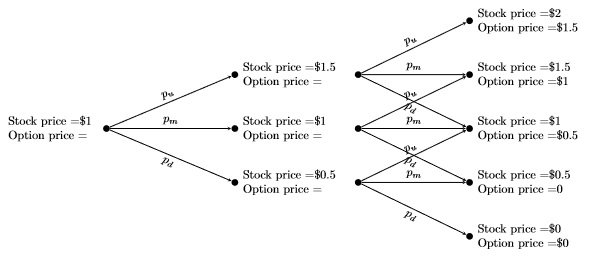

Again, we know the values for the option at the five end points. (Check those option prices in the picture, are they correct?). To compute the option value at the root of the tree, we now have to step back twice.
First, we want to compute the option values in the three nodes halfway the process. You can imagine this to be after half a year, if the total maturity time of the option is one year. In the picture, you can see that after half a year, stock prices will take three possible values: 0.5, 1 and 1.5. We do this as before: the upper node in the middle stage should have an option value that will be the weighted average of the three end points that can be reached from that point:

$$
\mbox{Option price in the upper node halfway}=p_u\cdot 1.5 + p_m\cdot 1 + p_d\cdot 0.5
$$

and similarly for the middle node in the middle (with stock price 1), and the lower node (with stock price $0.5$).
Once we have computed those three option values in the middle of the process, we step back once again to get the option value at the initial node, the root of the tree. This value will again be the weighted average of the three middle option values that we just computed.  

Before we will look at a function which computes those three middle option prices (one step back from the final five nodes), it is convenient to explore the Python concept of *slices* of an array.

Recall that if we have an array, say the array $x$ with 5 elements, its elements are numbered, from 0 to 4: $x$ consists of x[0], x[1], x[2], x[3] and x[4].

We can also reference a part of the array: x[i:j] denotes the *subarray* of $i$th element, up to *but not including* the $j$th element. Check it out by running the code below, and making sure you understand why the output is what it is:

In [ ]:
x=np.linspace(1,5,5)

x, x[0:3], x[1:4], x[:4], x[2:], x[:]

### Exercise
Just to make sure we understand this, do the following:
Write a function, called **shift(x)**, that given some array called x with elements x[0], x[1], ... , x[n], produces a new array of the same length, with as first element x[1], second element x[2], etc, and final element zero.
For example, if $x= [1,2,3,4]$, we want **shift**$(x)=[2,3,4,0]$.

Use slices as just discussed in this function. You can use the following template:

In [ ]:
def shift(x):
    #1. first measure the length of array x, call it L (use the len() function)
    #2. then construct an array y, of the same length, consisting of only zeros 
    #   (use the np.zeros() function for that)
    #3. then fill the slice of y containing the first L-1 elements of y with the last L-1 elements of x 
    #4. return y
    ...
    

Then try out your shift function to see whether it works as intended.

Now we can go ahead and define a function that steps back from the final five nodes in the 2-period trinomial tree above, to compute the three option values in the middle step.

We will define this function, with as inputs the probabilities, $p_u, p_m, p_d$, and an array containing the five option values at the end points. The output will be an array with five values, in which we will give the first and last elements value 0, and the middle three values will be the weighted averages that are the option values in the middle step of the trinomial tree. 

In [ ]:
def step_back_tree_2(pu,pm,pd, five_values):
    # five_values are the option values at the end points
    # for the output, the option values halfway the tree, we first define an array of five zeros:
    option_values = np.zeros(5)
    
    #Next, we fill the middle three elements of this array with the weighted averages 
    #of the end values, as in the tree.
    #We use slices for that: 
    option_values[1:4]=pu*five_values[2:5]+ pm*five_values[1:4]+pd*five_values[0:3]
    
    return option_values
    

Check out whether you understand each line in this function. Then try it out: create an array of the five stock prices at the end points. Then create the array of five option values using the **call_payoff()** function. Use this as an input in **step_back_tree_2()**, with probabilities again 0.25, 0.5 and 0.25.
What do you get?

To get the initial option price, at the root of the 2-period trinomial tree, we have to step back once again, from the middle period to the initial period. Adapt the one period function **step_back_1()**, that we defined previously, so that it takes as an input ("values") a *five-element array* (the option prices in the middle period, with a zero in the first and last positions), and returns a *five-element array* of zeros, except for the middle element which should be the option value at the initial point.

In [ ]:
# adapt this function:
def step_back_tree_1(pu,pm,pd, values):
    option_value = pu*values[2]+pm*values[1]+pd*values[0]
    return option_value

Once this is done, we can combine the two steps into one program, to compute the two-period trinomial tree option value for any strike price. It should look somewhat like this; complete the following program.

In [ ]:
def two_period_option_price(pu,pm,pd, strike):
    #first create the five stock values, between 0 and 2, at the end points:
    S=np.linspace(0,2,5)
    
    # now compute the option values, using call_payoff()
    option_values=...
    
    # step back from period 2 to period 1, using step_back_tree_2(), 
    # and option_values as input-array for that function,
    # to get the array of option values in period 1
    option_values_1= ...
    
    #step back again, using step_back_tree_1(), to get the option value in the initial point, period 0
    # use option_values_1, just computed, as the input-array for this function; the output-array is 
    # called result 
    result = ...
    
    return result

For strike price 0.5, I got as a result an option price of 0.53125. Did you find the same?

### Generalization: many periods

We could easily have done these calculations on paper, or in excel, of course. The reason why we want to use a program is because we can now generalize this procedure, and split up the time period between start date (time $t=0$) and end date (time is $T$) in not just one or two periods, but in arbitrarily many periods. As the number of periods (rebranchings of the tree) increases, we generate more and more densely spaced end points, and approximate the continuous reality more and more.

You can check that if we have branchings $N$ times, we will end up with $2N+1$ end points: with our single tree, $N=1$ and we have three end points; with our two-period tree we had $N=2$ and five end points, and so on.

If we have $N$ rebranchings, we need to step back $N$ times through this tree, from end time $T$ to starting time $0$. Of course we do not want to write a separate **step_back()** function, as above, for each of these steps. Rather, since the step-back procedures each step are rather similar, we would like to have a single function which we can invoke each time. 

Let us therefore generalize our step_back procedure into one function **step_back_tree(pu,pm,pd, values,n)**, taking one additional argument $n$, measuring which step we are taking.

In [ ]:
def step_back_tree(pu,pm,pd, values,n):
    # n measures how many steps back from the endpoints of the tree we are:
    # n=1 is the first iteration (stepping back from the final values at maturity to one 
    # time-period before that), etc., until at n=N we reach the initial node, the root of the tree.
    
    #first check how long your input array of values is
    length = len(values)
    
    # prepare the output array as one filled with zeros
    option_values = np.zeros(length)
    
    # now step back, filling only the center elements with values, and leave the first n elements,
    # and the last n elements, equal to zero
    option_values[n:length-n] = pu*values[n+1:length-n+1]+pm*values[n:length-n] \
    +pd*values[n-1:length-n-1]
    
    return option_values

Make sure you *fully* understand this code. Does it give the same results as our previous separate step_back functions, for appropriate values of n? Try it out.

Now, we can use this generalized step-back function, running it repeatedly to work our way backwards in a tree of arbitrary length. Let us see how we can do that.
To run a piece of code repeatedly, we can use a *for-loop*. Check out the following example:

In [ ]:
for i in range(1,4):   
    print('hello')  # the indentation at the front of this line is required by python

The function **range(1,4)** creates an array [1,2,3] with three numbers, starting with 1, up to but not including 4. The **for** statement tells python to let the variable $i$ iterate through those three numbers, and for every iteration, run the code that follows after the ":". Can you guess the output of the following code?

In [ ]:
for i in range(1,5):
    print(i)

Let's now use the **for**-statement to iterate stepping backwards in our two-period trinomial tree, executing the step-back function twice, to create the option price at time zero.

In [ ]:
def two_period_tree(strike):
    
    #first define the five stock prices at the end, and the tree-probabilities
    S=np.linspace(0,2,5)
    pu, pm, pd= 0.25, 0.5, 0.25
    
    #next, define the payoffs for the option at the five end points, for the given strike price
    values= call_payoff(strike, S)
    
    #now use a for-loop to step back twice to produce the initial values
    for n in range(1,3):  # n takes the values one and two
        intermediate_option_prices=step_back_tree(pu,pm,pd, values,n)
        values = intermediate_option_prices  #update our values-array for the next step
        
    return values  #note: the end of the indentation tells python here is where the for-loop ends  
    

Check whether it works. Do you get the same option price as before? (It was 0.53125 for strike price 0.5).

In [ ]:
two_period_tree(0.5)

Adapt the two-period tree function to an $N$-period tree, using the template below. Keep the stock prices at the end-points between 0 and 2. How many end points will you get?

In [ ]:
def N_period_tree(strike, N):
    
    #first define the stock prices at the end, and the tree-probabilities
    S=...
    pu, pm, pd= 0.25, 0.5, 0.25
    
    #next, define the payoffs for the option at the end points, for the given strike price
    values= call_payoff(strike, S)
    
    #now use a for-loop to step back N times to produce the initial values
    ...
    
    return values  #note: the end of the indentation tells python here is where the for-loop ends  


Do you get the same result as before for $N=2$? You can now just as easily compute for more periods, try e.g. $N=10$. To what value does it converge as $N$ grows bigger?

We are actually only interested in the middle, non-zero element of the result. You can change your function so that it only outputs that result (what is its index, for arbitrary $N$?)

### The Black-Scholes process

We are almost there. So far, we used some arbitrary process for our stock price behaviour, described by the constant step probabilities $p_u,p_m, p_d=0.25, 0.5, 0.25$, and the stock price array between $0$ and $2$. We would like to change this so that the limit of our trinomial stock price process (for large number of steps $N$) generates the Black-Scholes process, with some volatility $\sigma$, some initial stock value $S_0$, a time to maturity $T$, an interest rate $r$, a dividend yield $div$.

For those who have taken a derivatives course, we want $S$ to follow geometric Brownian motion,
$$
dS = (r-div)S dt + \sigma S dz.
$$

If we manage to do that right, we can hope to reproduce the Black-Scholes option price with our trinomial tree, in the limit where we take the number of steps $N$ large. 

First, if we interpret the time between beginning and end of the tree as $T$, then if we have $N$ steps, each step will account for a duration $dt= T/N$.

Second, instead of taking our array of stock prices equally spaced between some upper and lower bound, it turns out to be more convenient now to take the logarithms of $S$ equally spaced. To get the stock prices themselves, we need to take $e$ to the power of those logarithms. 

We will refer to the step size of this array of *logarithms* of $S$ as $dx$. It turns out that it is necessary to choose this step size related to the time step $dt$, and to the volatility $\sigma$. A good choice is
$$
dx =\sigma \sqrt{3\cdot dt}.
$$
The stock price array will now have our initial stock price $S_0$ in the center, increase by a factor $e^{dx}$ for each move up, and decrease by $e^{-dx}$ for a move down.

For this choice of our stock price array, it is still appropriate to choose our probabilities constant throughout the tree. To get the correct Black-Scholes process, it turns out these will have to be taken as (with $\nu = r- div - \frac{1}{2}\sigma^2$):
$$
p_u = \frac{1}{2}dt\cdot \left((\sigma/dx)^2 + \nu/dx \right),
$$
$$
p_m = 1 - dt\cdot(\sigma/dx)^2 - r\cdot dt,
$$
$$
p_d = \frac{1}{2}dt\cdot \left((\sigma/dx)^2 - \nu/dx \right).
$$
Incidentally, these expressions now also take care of the discounting that we ignored so far.

Technical details of why these expressions give rise to the Black-Scholes stock price process can be found in Clewlow and Strickland, chapter 3.

The following function produces these probabilities, and the array of stock prices.

In [ ]:
def set_parameters(S_0, T, r, sigma, div, N):
    
    # define the parameters as just outlined:
    
    dt = T/N
    dx = sigma*np.sqrt( 3*dt )
    nu = r- div- 0.5 * sigma**2
    
    pu = (1/2)*dt* ( (sigma/dx)**2 + nu/dx )
    pm = 1 - dt*(sigma/dx)**2 - r*dt
    pd = (1/2) * dt * ( (sigma/dx)**2 - nu/dx )
    
    # define the array of stock prices: it will be 2N+1 elements long, with S_0 as the middle value
    # each value up will be e^dx larger, while a value down will be e^(-dx) smaller

    S_array = S_0 * np.exp(dx * np.linspace(-N,N, 2*N+1))
    
    #this function gives as output the three probabilities and the 2N+1 array of stock prices.
    return pu, pm, pd, S_array

Now we use these computed parameters representing the Black-Scholes process for the stock price, instead of our earlier arbitrary probabilities and stock price values. The rest of the following code is just the same **N_period_tree()** that we had before.

In [ ]:
def European_call_option(S_0, T, r, sigma, div, N, strike):
    
    # first set the parameters; note that this function gives a whole bunch of outputs at once:
    pu, pm, pd, S_array = set_parameters(S_0, T, r, sigma, div, N)
    
    #next, define the payoffs for the option at the end points, for the given strike price
    values= call_payoff(strike, S_array)
    
    #now use a for-loop to step back N times to produce the initial values
    for n in range(1,N+1):
        intermediate_option_prices=step_back_tree(pu,pm,pd, values,n)
        values = intermediate_option_prices  #update our values-array for the next step
        
    
    return values[N] # we want to get the middle (index $N$) element of this array, 
                        #which corresponds to the root of the tree  

Now we can try it out. For example, for a three-step trinomial tree, and option parameters
$S_0=100, T=1, r=0.06, \sigma=0.2, div=0.03$ and strike price $K=100$, I find a computed option price of 8.5455.

## Exercises

### 1. Approximating the Black-Scholes option price

Last time, we programmed the Black-Scholes price of a call option, $C(S)$. Including now also the dividend yield $div$, it is 
$$
C(S)= e^{-div\cdot T}SN(d_1)- e^{-rT} K N(d_2)
$$
where $r$ is the interest rate, $N()$ is the distribution function of the standard normal distribution,
\begin{align}
d_1 & =\frac{1}{\sigma \sqrt{T}}\left( \ln\left(\frac{S}{K}\right)+\left(r- div +\frac{\sigma^2}{2}\right)T\right),\\
d_2 & =\frac{1}{\sigma \sqrt{T}}\left( \ln\left(\frac{S}{K}\right)+\left(r- div -\frac{\sigma^2}{2}\right)T\right),
\end{align}

* Adapt your function computing $C(S)$ to include also this dividend yield. Do not forget to also import the cumulative normal density **norm** from **scipy.stats**, as you did last time. 

* Now, we hope that our trinomial tree becomes a good approximation to the Black-Scholes formula value $C(S)$. Try it for the same parameters $S_0=100, T=1, r=0.06, \sigma=0.2, div=0.03$ and strike price $K=100$. What is the Black-Scholes price, $C(100)$? Does the three step trinomial tree give a good approximation to the Black-Scholes value? Does it get better with a higher number of steps $N$? Is $N=100$ good? Or $N=1000$? At what $N$ is your computer getting noticeably slower? 

* Let us check how large we should take the number of steps in the trinomial tree to get a decent approximation to the Black-Scholes value. We can define the relative approximation error, for a given choice of steps $N$, as follows,

$$
\mbox{approximation error}=\frac{C(100)- \mbox{trinomial result(N steps)}}{C(100)}
$$

In [ ]:
def approximation(N):

    # the difference between the real Black-Scholes value, C(100), and the 
    # result of the trinomial tree with N steps, divided by C(100),
    # gives the relative approximation error:
    
    return (C(100)-European_call_option(100, 1, 0.06, 0.2, 0.03, N, 100))/C(100)

You can try for instance how well the trinomial tree with 100 steps ($N=100$), approximates the Black-Scholes value. The answer turns out to be that the valuation error is about 0.17 percent.

In [ ]:
approximation(100)

Let us now plot a graph depicting how fast the approximation error goes down as we increase the number of steps $N$. To do so, we need to have, on the x-axis, an array of values for $N$, the progressively increasing number of steps; e.g. [100,200,300,400,500]. And as y-values, we need to have the corresponding approximation errors for those values of $N$, i.e. **approximation(100)** up to **approximation(500)**.

To create an array of $N$-values, we can use the function **np.arange()**. Google it to see how  it works, and use it to create the array N=[100,200,300,400,500].


Now we would like to just let our function **approximation()** operate on this array of $N$-values, rather than on a single $N$. Unfortunately that does not work (try it!); our self-defined function **approximation()** cannot take a whole array as an input, to produce an array of outputs.

To make this work in **numpy**, we can use a trick called **vectorization**: run the following cell.

In [ ]:
vect_app=np.vectorize(approximation)

This defines a new function **vect_app()** from our old function **approximation()**. The function **vect_app()** is what we need: it applies our function **approximation()** to each of the elements in an array of $N$ values; try it on your array $N$. 

In [ ]:
vect_app(N)

Now go ahead and make a plot. Look back to last week's notebook how that was done. Do not forget to import the plotting library, **matplotlib.pyplot**, and to include a line

**%matplotlib inline**

to tell Python that it should draw the plot right here in this notebook.

Then plot the function (be careful how many values you compute, it might take some computing time!)

When it works, see if you can also add axis-legends to the horizontal and vertical axes, describing what  you are plotting, and perhaps also a title for the graph.

### 2. Adapt the function to compute a European put option

A put option with strike price $K$ has the pay-off $\max (K-S,0)$. Adapt what we have to create the function **European_put_option()** that computes a put using an $N$-step trinomial tree. You can also compare the result of your trinomial tree function with the Black-Scholes formula for a European put option.